In [4]:
import os
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
SYM_PATH = '/content/gdrive/MyDrive/cs285_f2022/proj'
%cd $SYM_PATH

/content/gdrive/MyDrive/cs285_f2022/proj


In [ ]:
# install contextualbandits
!pip install git+https://github.com/HaodongL/cs285_proj
!pip install costsensitive

In [13]:
# Off-policy Learning in Contextual Bandits

In [9]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

features, y = parse_data("Bibtex_data.txt")
print(features.shape)
print(y.shape)

(7395, 1836)
(7395, 159)


In [10]:
from sklearn.linear_model import LogisticRegression

# the 'explorer' polcy will be fit with this small sample of the rows
st_seed = 0
end_seed = 3000

# then it will choose actions for this larger sample
st_exploration = 0
end_exploration = 5000

# the new policy will be evaluated with a separate test set
st_test = 5000
end_test = 7395

# separating the covariates data for each case
Xseed = features[st_seed:end_seed, :]
Xexplore_sample = features[st_exploration:end_exploration, :]
Xtest = features[st_test:end_test, :]
nchoices = y.shape[1]

# now constructing an exploration policy as explained above, with fully-labeled data
explorer = LogisticRegression(solver="lbfgs", max_iter=15000)
explorer.fit(Xseed, np.argmax(y[st_seed:end_seed], axis=1))

# letting the exploration policy choose actions for the new policy input
actions_explore_sample = explorer.predict(Xexplore_sample)
rewards_explore_sample = y[st_exploration:end_exploration, :]\
                        [np.arange(end_exploration - st_exploration), actions_explore_sample]

# extracting the probabilities it estimated
ix_internal_actions = {j:i for i,j in enumerate(explorer.classes_)}
ix_internal_actions = [ix_internal_actions[i] for i in actions_explore_sample]
ix_internal_actions = np.array(ix_internal_actions)
prob_actions_explore = explorer.predict_proba(Xexplore_sample)[np.arange(Xexplore_sample.shape[0]),
                                                               ix_internal_actions]

In [11]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior=None, smoothing=None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_naive = np.mean(y[st_test:end_test, :]\
                             [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers: ", mean_reward_naive)

Test set mean reward - Separate Classifiers:  0.01962421711899791


In [12]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior="auto")
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_beta = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Prior: ", mean_reward_beta)

Test set mean reward - Separate Classifiers + Prior:  0.09394572025052192


In [13]:
from contextualbandits.online import SeparateClassifiers
from sklearn.linear_model import LogisticRegression

new_policy = SeparateClassifiers(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000),
                                 nchoices=y.shape[1], beta_prior=None, smoothing = (1,2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample)
mean_reward_sm = np.mean(y[st_test:end_test, :]\
                            [np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Separate Classifiers + Smoothing: ", mean_reward_sm)

Test set mean reward - Separate Classifiers + Smoothing:  0.17995824634655533


In [14]:
from contextualbandits.offpolicy import OffsetTree
from sklearn.linear_model import LogisticRegression

new_policy = OffsetTree(base_algorithm=LogisticRegression(solver="lbfgs", max_iter=15000), nchoices=y.shape[1])
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_ot = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Offset Tree technique: ", mean_reward_ot)

Test set mean reward - Offset Tree technique:  0.3173277661795407


In [18]:
from contextualbandits.offpolicy import DoublyRobustEstimator
from sklearn.linear_model import LogisticRegression, Ridge

new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator: ", mean_reward_dr)


new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = "auto", smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_prior = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Prior: ", mean_reward_dr_prior)


new_policy = DoublyRobustEstimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = (1, 2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_dr_sm = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - Doubly-Robust Estimator + Smoothing: ", mean_reward_dr_sm)

Test set mean reward - Doubly-Robust Estimator:  0.04634655532359081
Test set mean reward - Doubly-Robust Estimator + Prior:  0.08058455114822546
Test set mean reward - Doubly-Robust Estimator + Smoothing:  0.07348643006263048


In [19]:
from contextualbandits.offpolicy import TMLE_Estimator
new_policy = TMLE_Estimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_tmle = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - TMLE_Estimator Estimator: ", mean_reward_tmle)

new_policy = TMLE_Estimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = "auto", smoothing = None)
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_tmle_prior = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - TMLE_Estimator Estimator + Prior: ", mean_reward_tmle_prior)

new_policy = TMLE_Estimator(base_algorithm = Ridge(),
                                   reward_estimator = LogisticRegression(solver="lbfgs", max_iter=15000),
                                   nchoices = y.shape[1],
                                   method = 'rovr', beta_prior = None, smoothing = (1, 2))
new_policy.fit(X=Xexplore_sample, a=actions_explore_sample, r=rewards_explore_sample, p=prob_actions_explore)
mean_reward_tmle_sm = np.mean(y[st_test:end_test, :][np.arange(end_test - st_test), new_policy.predict(Xtest)])
print("Test set mean reward - TMLE_Estimator Estimator + Smoothing: ", mean_reward_tmle_sm)

Test set mean reward - TMLE_Estimator Estimator:  0.04634655532359081
Test set mean reward - TMLE_Estimator Estimator + Prior:  0.08058455114822546
Test set mean reward - TMLE_Estimator Estimator + Smoothing:  0.07348643006263048


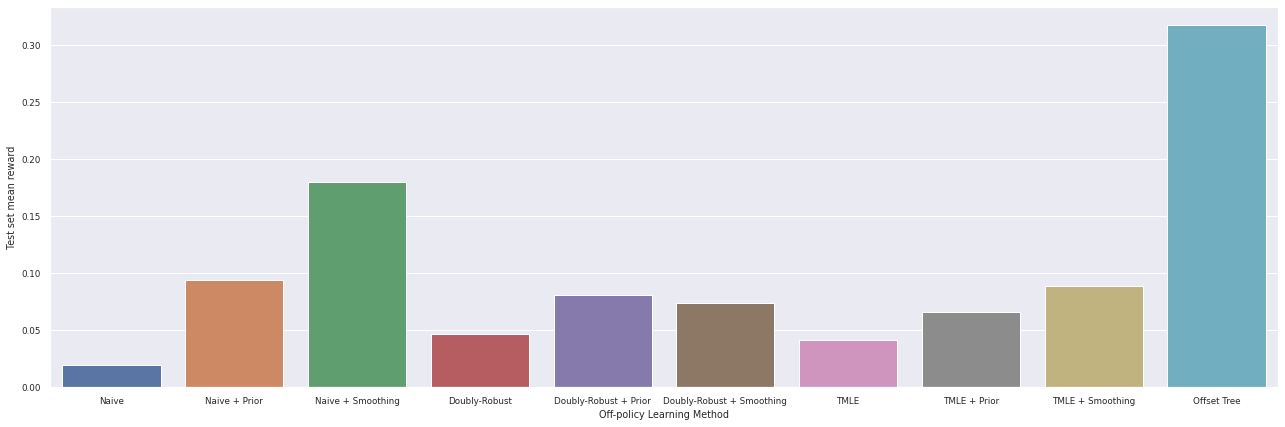

In [28]:
import matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
from pylab import rcParams
%matplotlib inline

results = pd.DataFrame({
    'Off-policy Learning Method' : ['Naive', 'Naive + Prior', 'Naive + Smoothing', 
                                    'Doubly-Robust','Doubly-Robust + Prior', 'Doubly-Robust + Smoothing', 
                                    'TMLE','TMLE + Prior', 'TMLE + Smoothing', 
                                    'Offset Tree'],
    'Test set mean reward' : [mean_reward_naive, mean_reward_beta, mean_reward_sm, mean_reward_dr,
                              mean_reward_dr_prior, mean_reward_dr_sm, mean_reward_tmle,
                              mean_reward_tmle_prior, mean_reward_tmle_sm, mean_reward_ot]
})

sns.set(font_scale = 0.8)
rcParams['figure.figsize'] = 22, 7
sns.barplot(x = "Off-policy Learning Method", y="Test set mean reward", data=results)
plt.title('Off-policy Learning on Bibtex Dataset\nBase Classifier is Logistic Regression')
plt.savefig("p_offpolicy")